In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")

from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features, preprocess_data
price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.cboe_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)
dates = dataset['date'].copy().squeeze().drop_duplicates().reset_index(drop=True)
dates


##################
# training start #
##################

Sat Nov  2 13:08:21 2024



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2785/2785 [00:38<00:00, 72.59it/s]


0     2024-10-16
1     2024-10-15
2     2024-10-14
3     2024-10-12
4     2024-10-11
         ...    
170   2024-03-12
171   2024-03-11
172   2024-03-09
173   2024-03-08
174   2024-03-07
Name: date, Length: 175, dtype: datetime64[ns]

44 131


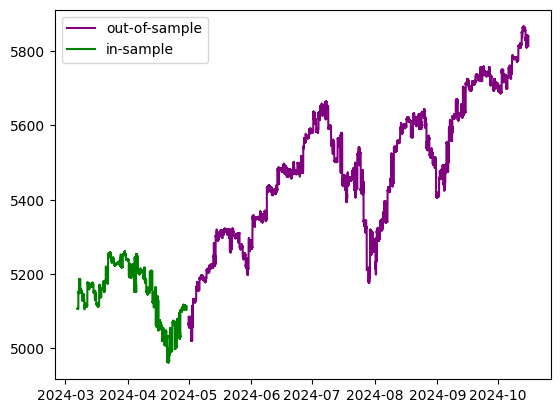

In [2]:
development_dates = dates.iloc[-len(dates)//4:]
test_dates = dates[~dates.isin(development_dates)]
print(len(development_dates),len(test_dates))
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
preprocessor = preprocessed['preprocessor']
test_data = preprocessed['test_data']
train_data = preprocessed['train_data']
train_test = preprocessed['train_test_arrays']
train_X = train_test['train_X']
train_y = train_test['train_y']
test_X = train_test['test_X']
test_y = train_test['test_y']

## stacked regressor

In [3]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer,FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params['max_iter'] = 1000
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 1000,
 'warm_start': True,
 'tol': 0.0001}

In [4]:
numerical_scaler = StandardScaler()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 
    # 'barrier',
    'v0',
    # 'theta',
    # 'kappa',
]

ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)

ridge_pipeline = make_pipeline(ridge_preprocessor, RidgeCV())

test_ridge = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

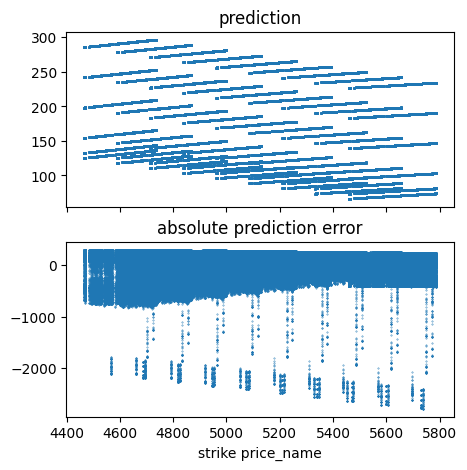


train spots:
calculation_date
2024-03-06 16:34:02.349    4962.00
2024-03-06 16:48:21.589    4963.00
2024-03-06 16:59:57.454    4963.25
2024-03-06 16:57:40.470    4963.50
2024-03-06 16:34:02.349    4963.75
                            ...   
2024-04-29 15:59:38.468    5258.50
2024-04-29 15:59:46.764    5258.75
2024-04-29 15:59:46.764    5259.00
2024-04-29 15:59:26.091    5260.00
2024-04-29 15:59:38.468    5261.75
Name: spot_price, Length: 551, dtype: float64


TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('scaling',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'v0'])])),
                                                     ('ridgecv', RidgeCV())]),
                           transformer=StandardScaler())

In [5]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions,s=0.1)
axs[0].set_title('prediction')
axs[1].scatter(K,diff,s=0.1)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price_name')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_scaler,trainer.numerical_features),
        ('categorical',OneHotEncoder(),trainer.categorical_features)
    ]
)

mlp_pipeline = make_pipeline(preprocessor,MLPRegressor(**trainer.dnn_params))
stacked_regressor = StackingRegressor(
    estimators=[
        ('dnn',mlp_pipeline),
        ('ridge',ridge_pipeline)
    ],
    final_estimator=GradientBoostingRegressor()
)
meta = TransformedTargetRegressor(regressor=stacked_regressor,transformer=numerical_scaler)
meta

TransformedTargetRegressor(regressor=StackingRegressor(estimators=[('dnn',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('numerical',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                                       'kappa',
                                                                                                                       'theta',
                                                                                                                       'rho',
                                                                                                                       'eta',
                                                                                                                       'v0',
                                                                                                                       'barrier']),
                                                                                                                     ('categorical',
                                                                                                                      OneHotEncoder(),
                                                                                                                      ['barrier_type_name'...
                                                                                                  learning_rate_init=0.1,
                                                                                                  max_iter=1000,
                                                                                                  solver='sgd',
                                                                                                  warm_start=True))])),
                                                                   ('ridge',
                                                                    Pipeline(steps=[('columntransformer',
                                                                                     ColumnTransformer(transformers=[('scaling',
                                                                                                                      StandardScaler(),
                                                                                                                      ['spot_price',
                                                                                                                       'strike_price',
                                                                                                                       'days_to_maturity',
                                                                                                                       'risk_free_rate',
                                                                                                                       'dividend_rate',
                                                                                                      

## testing specification

In [ ]:
meta.fit(train_X,train_y)
P = meta.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
end = time.time()
runtime = end-train_start
print(f"cpu: {runtime}")
print(f"\n\nMAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
testP = meta.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")

### versus original

In [ ]:
dnn = barrier_trainer.run_dnn(preprocessor, train_X, train_y)
P = dnn.predict(train_X)
diff = train_y - P
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"\n\nin sample:\nMAE: {MAE}\nRMSE: {RMSE}")

In [ ]:
testP = dnn.predict(test_X)
diff = test_y - testP
RMSE = np.sqrt(np.mean(diff**2))
MAE = np.mean(np.abs(diff))
print(f"MAE: {MAE}\nRMSE: {RMSE}")